In [1]:
!pip install obci_readmanager

     |████████████████████████████████| 61kB 1.9MB/s 
     |████████████████████████████████| 6.2MB 4.3MB/s 
  Created wheel for mne: filename=mne-0.17.2-cp37-none-any.whl size=6194609 sha256=528eb0b6632700afddee97e6d7aa0e3f34dabbdd9e3556ecc2831f3931770fe8
  Stored in directory: /root/.cache/pip/wheels/e4/be/8b/6b737d272fb91d42e7ac5d61cc93227df7d71944e0e0eb15dd
Successfully built mne


In [2]:
from obci_readmanager.signal_processing.read_manager import ReadManager as rm
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from obci_readmanager.signal_processing.smart_tags_manager import SmartTagsManager
from obci_readmanager.signal_processing.tags.smart_tag_definition import (
                    SmartTagDurationDefinition,
                    SmartTagEndTagDefinition)
import math

In [3]:
xml = "/content/Franek_EMG_R1.xml"
raw = "/content/Franek_EMG_R1.raw"
tag = "/content/Franek_EMG_R1.tag"
mgr = rm(xml,raw,tag)

sampling = float(mgr.get_param("sampling_frequency"))
num_of_channels = int(mgr.get_param("number_of_channels"))
channels_names = mgr.get_param("channels_names")

mgr_info = (sampling, num_of_channels, channels_names)
for i in mgr_info:
  print(i)

syg_raw = mgr.get_samples()

2021-06-10 08:24:08,831 - data_source - INFO - All data set requested for the first time. Start reading all data from the file...


2048.0
5
['ExG5', 'ExG6', 'ExG7', 'ExG8', 'TSS']


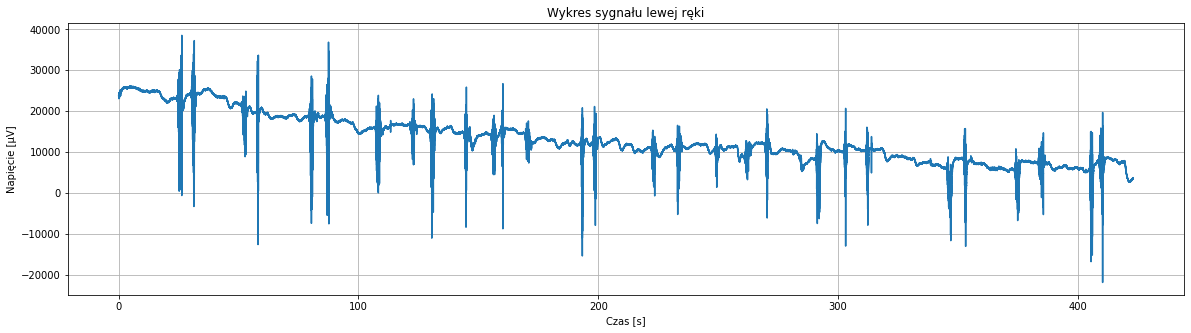

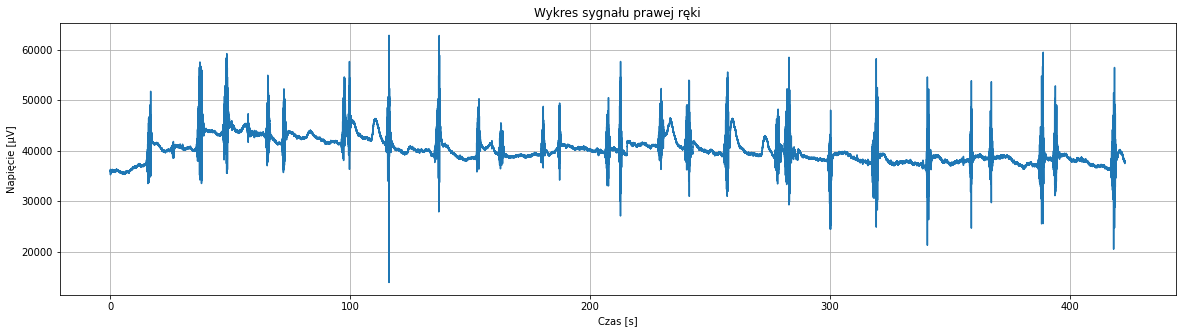

In [7]:
syg_lewa = syg_raw[0] - syg_raw[1]
syg_lewa = np.array(syg_lewa)
t = np.arange(0, len(syg_lewa)/sampling,1/sampling)
plt.figure(figsize=(20, 5))
plt.plot(t, syg_lewa)
plt.grid()
plt.xlabel('Czas [s]')
plt.ylabel('Napięcie [µV]')
plt.title('Wykres sygnału lewej ręki')
plt.show()


syg_prawa = syg_raw[2] - syg_raw[3]
syg_prawa = np.array(syg_prawa)
plt.figure(figsize=(20, 5))
plt.plot(t, syg_prawa)
plt.grid()
plt.xlabel('Czas [s]')
plt.ylabel('Napięcie [µV]')
plt.title('Wykres sygnału prawej ręki')
plt.show()



---
## Filtrowanie i kwadrat


In [8]:
filter = signal.butter(1, 1, btype='high', fs=2048, output='sos')
syg_lewa_filtered = signal.sosfilt(filter, syg_lewa)
syg_prawa_filtered = signal.sosfilt(filter, syg_prawa)

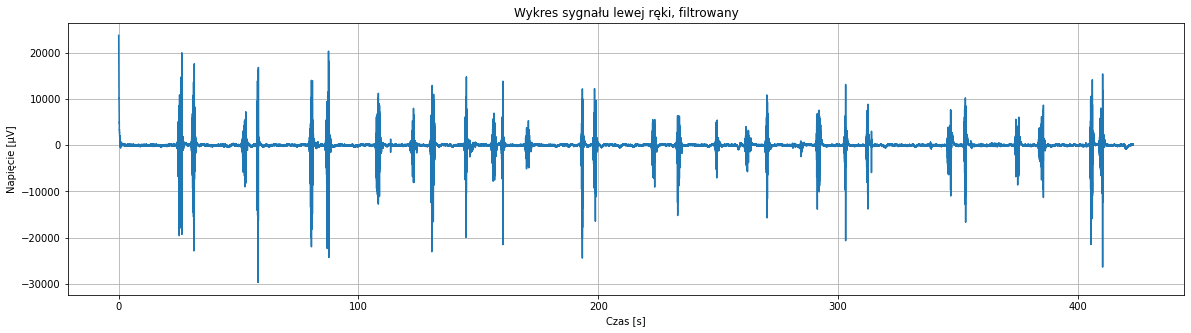

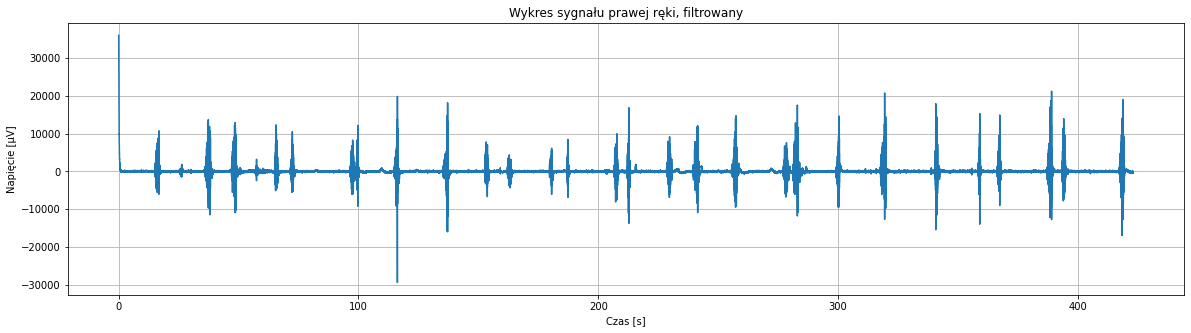

In [10]:
plt.figure(figsize=(20, 5))
plt.title('Wykres sygnału lewej ręki, filtrowany')
plt.grid()
plt.xlabel('Czas [s]')
plt.ylabel('Napięcie [µV]')
plt.plot(t, syg_lewa_filtered)
plt.show()

plt.figure(figsize=(20, 5))
plt.title('Wykres sygnału prawej ręki, filtrowany')
plt.grid()
plt.xlabel('Czas [s]')
plt.ylabel('Napięcie [µV]')
plt.plot(t, syg_prawa_filtered)
plt.show()



---
## Średnia biegnąca


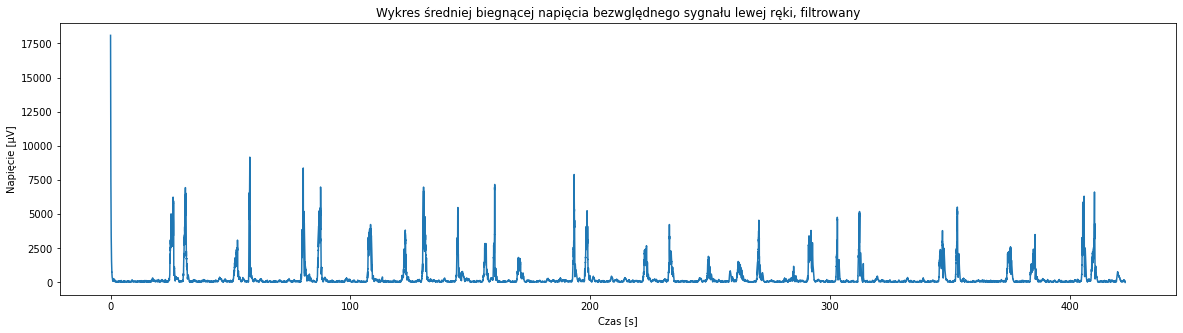

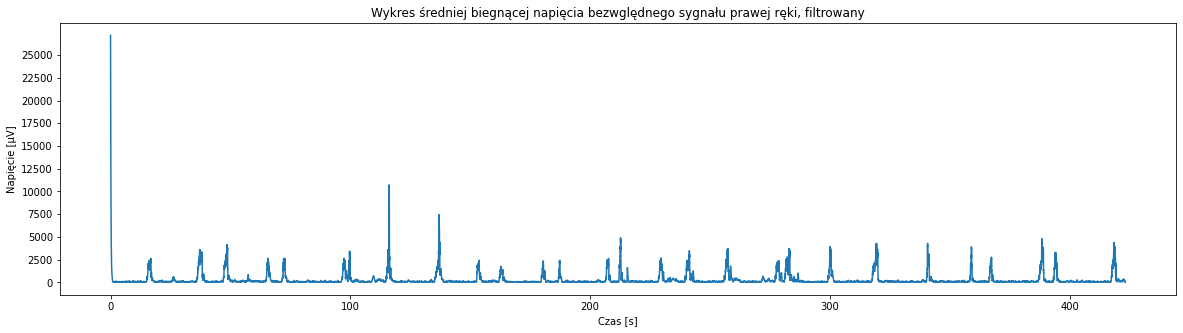

In [13]:
syg_lewa_windowed = np.zeros(len(syg_lewa_filtered))
mean_len = 204
syg_lewa_squared = syg_lewa_filtered**2 
for i in range(len(syg_lewa_filtered)):
  if i+mean_len > len(syg_lewa_filtered):
    break
  else:
    sample = np.mean(syg_lewa_squared[i:i+mean_len])
    syg_lewa_windowed[i] = sample
syg_lewa_windowed = syg_lewa_windowed**(1/2)

syg_prawa_windowed = np.zeros(len(syg_prawa_filtered))
mean_len = 204
syg_prawa_squared = syg_prawa_filtered**2
for i in range(len(syg_prawa_filtered)):
  if i+mean_len > len(syg_prawa_filtered):
    break
  else:
    sample = np.mean(syg_prawa_squared[i:i+mean_len])
    syg_prawa_windowed[i] = sample
syg_prawa_windowed = syg_prawa_windowed**(1/2)


plt.figure(figsize=(20, 5))
plt.title('Wykres średniej biegnącej napięcia bezwględnego sygnału lewej ręki, filtrowany')
plt.plot(np.arange(0, len(syg_lewa_windowed)/2048, 1/2048), syg_lewa_windowed)
plt.grid()
plt.xlabel('Czas [s]')
plt.ylabel('Napięcie [µV]')
plt.grid()
plt.show()

plt.figure(figsize=(20, 5))
plt.title('Wykres średniej biegnącej napięcia bezwględnego sygnału prawej ręki, filtrowany')
plt.plot(np.arange(0, len(syg_prawa_windowed)/2048, 1/2048), syg_prawa_windowed)
plt.grid()
plt.xlabel('Czas [s]')
plt.ylabel('Napięcie [µV]')
plt.yticks(np.arange(min(syg_prawa_windowed), max(syg_prawa_windowed)+1, 2500))
plt.grid()
plt.show()



---


# Detektor wersja podstawowa
Potem jest fajniejszy

In [15]:
#lewa
detektor = np.zeros(syg_lewa_windowed.shape)
detektor[syg_lewa_windowed<2500] = 1

tagi = []
poczatek_tagu = 0
look_for = detektor[0]
iterator = 0
for i in detektor:
  if i != look_for:
    tagi.append((poczatek_tagu, iterator-1, i))
    poczatek_tagu = iterator 
    look_for = i
  iterator += 1

tagi_detektor_lewa = [(x[0],x[1]) for x in tagi if x[2] == 1.0]



#prawa
detektor = np.zeros(syg_prawa_windowed.shape)
detektor[syg_prawa_windowed>1250] = 1

tagi = []
poczatek_tagu = 0
look_for = detektor[0]
iterator = 0
for i in detektor:
  if i != look_for:
    tagi.append((poczatek_tagu, iterator-1, i))
    poczatek_tagu = iterator 
    look_for = i
  iterator += 1

tagi_detektor_prawa = [(x[0],x[1]) for x in tagi if x[2] == 1.0]






---
# Wyświetlanie tagów z eksperymentu



In [17]:
tagi_sygnal = mgr.get_tags()
tagi_sygnal = np.array(tagi_sygnal)
tagi_sygnal_lewa_timestamp = []
tagi_sygnal_prawa_timestamp = []
for i in tagi_sygnal:
  if i['name'] == 'Lewa Ręka':
    tagi_sygnal_lewa_timestamp.append((i['start_timestamp'], i['end_timestamp']))
  elif i['name'] == 'Prawa Ręka':
    tagi_sygnal_prawa_timestamp.append((i['start_timestamp'], i['end_timestamp']))

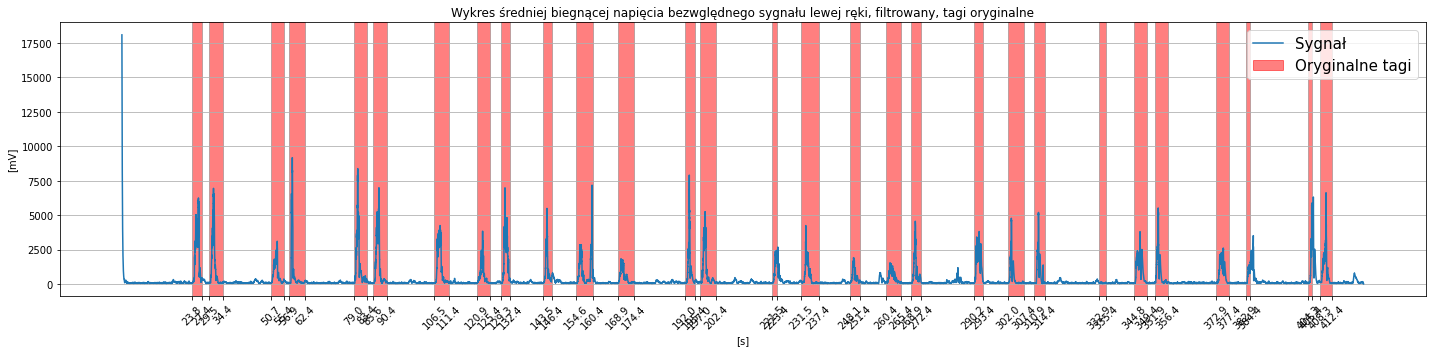

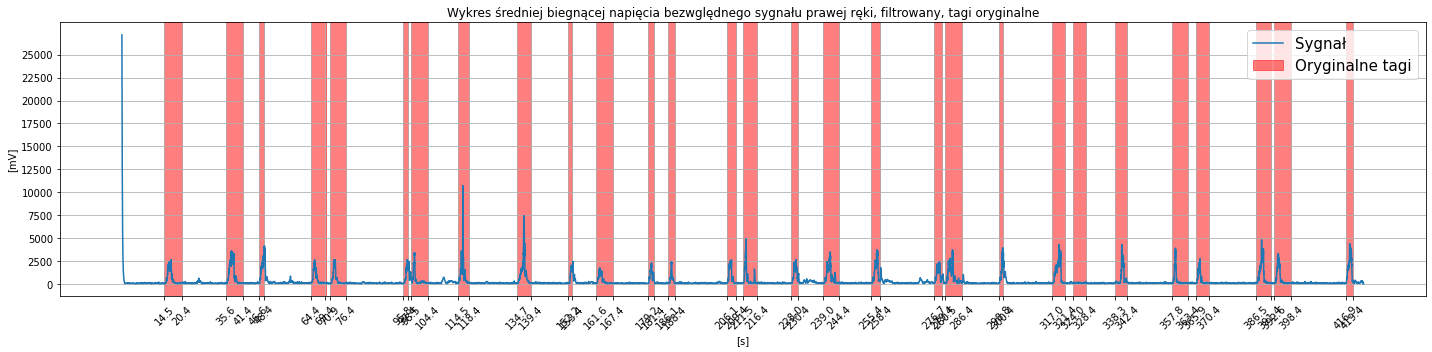

In [18]:
plt.figure(figsize=(20, 5))
for i in tagi_sygnal_lewa_timestamp:
  plt.axvspan(i[0], i[1], color='r', alpha=0.5)
plt.plot(np.arange(0, len(syg_lewa_windowed)/2048, 1/2048), syg_lewa_windowed)
plt.title('Wykres średniej biegnącej napięcia bezwględnego sygnału lewej ręki, filtrowany, tagi oryginalne')
plt.legend(['Sygnał', 'Oryginalne tagi'], fontsize=15)
plt.xticks(np.concatenate(np.round(tagi_sygnal_lewa_timestamp,2)), rotation=45)
plt.xlabel('[s]')
plt.ylabel('[mV]')
plt.tight_layout()
plt.grid()
plt.show()

plt.figure(figsize=(20, 5))
for i in tagi_sygnal_prawa_timestamp:
  plt.axvspan(i[0], i[1], color='r', alpha=0.5)
plt.plot(np.arange(0, len(syg_prawa_windowed)/2048, 1/2048), syg_prawa_windowed)
plt.yticks(np.arange(min(syg_prawa_windowed), max(syg_prawa_windowed)+1, 2500))
plt.title('Wykres średniej biegnącej napięcia bezwględnego sygnału prawej ręki, filtrowany, tagi oryginalne')
plt.legend(['Sygnał','Oryginalne tagi'], fontsize=15)
plt.xticks(np.concatenate(np.round(tagi_sygnal_prawa_timestamp,2)), rotation=45)
plt.xlabel('[s]')
plt.ylabel('[mV]')
plt.tight_layout()
plt.grid()
plt.show()

---
# Detektor wersja 2 - poprawiona
Detektor oblicza odchylenie standardowe sygnału dla wyciętych okienek oryginalnych tagów i rejestruje wykrycie po przekroczeniu 3 odchyleń standardowych, rejestracja kończy się po spadku poniżej 1 odchylenia. 

Po spadku często w sygnale rejestrowane było odbicie z powrotem w górę, jednak wydaje się ono nie mieć znaczącego wpływu na działanie detektora i warunki określone w pierwszym akapicie okazują się wystarczające.


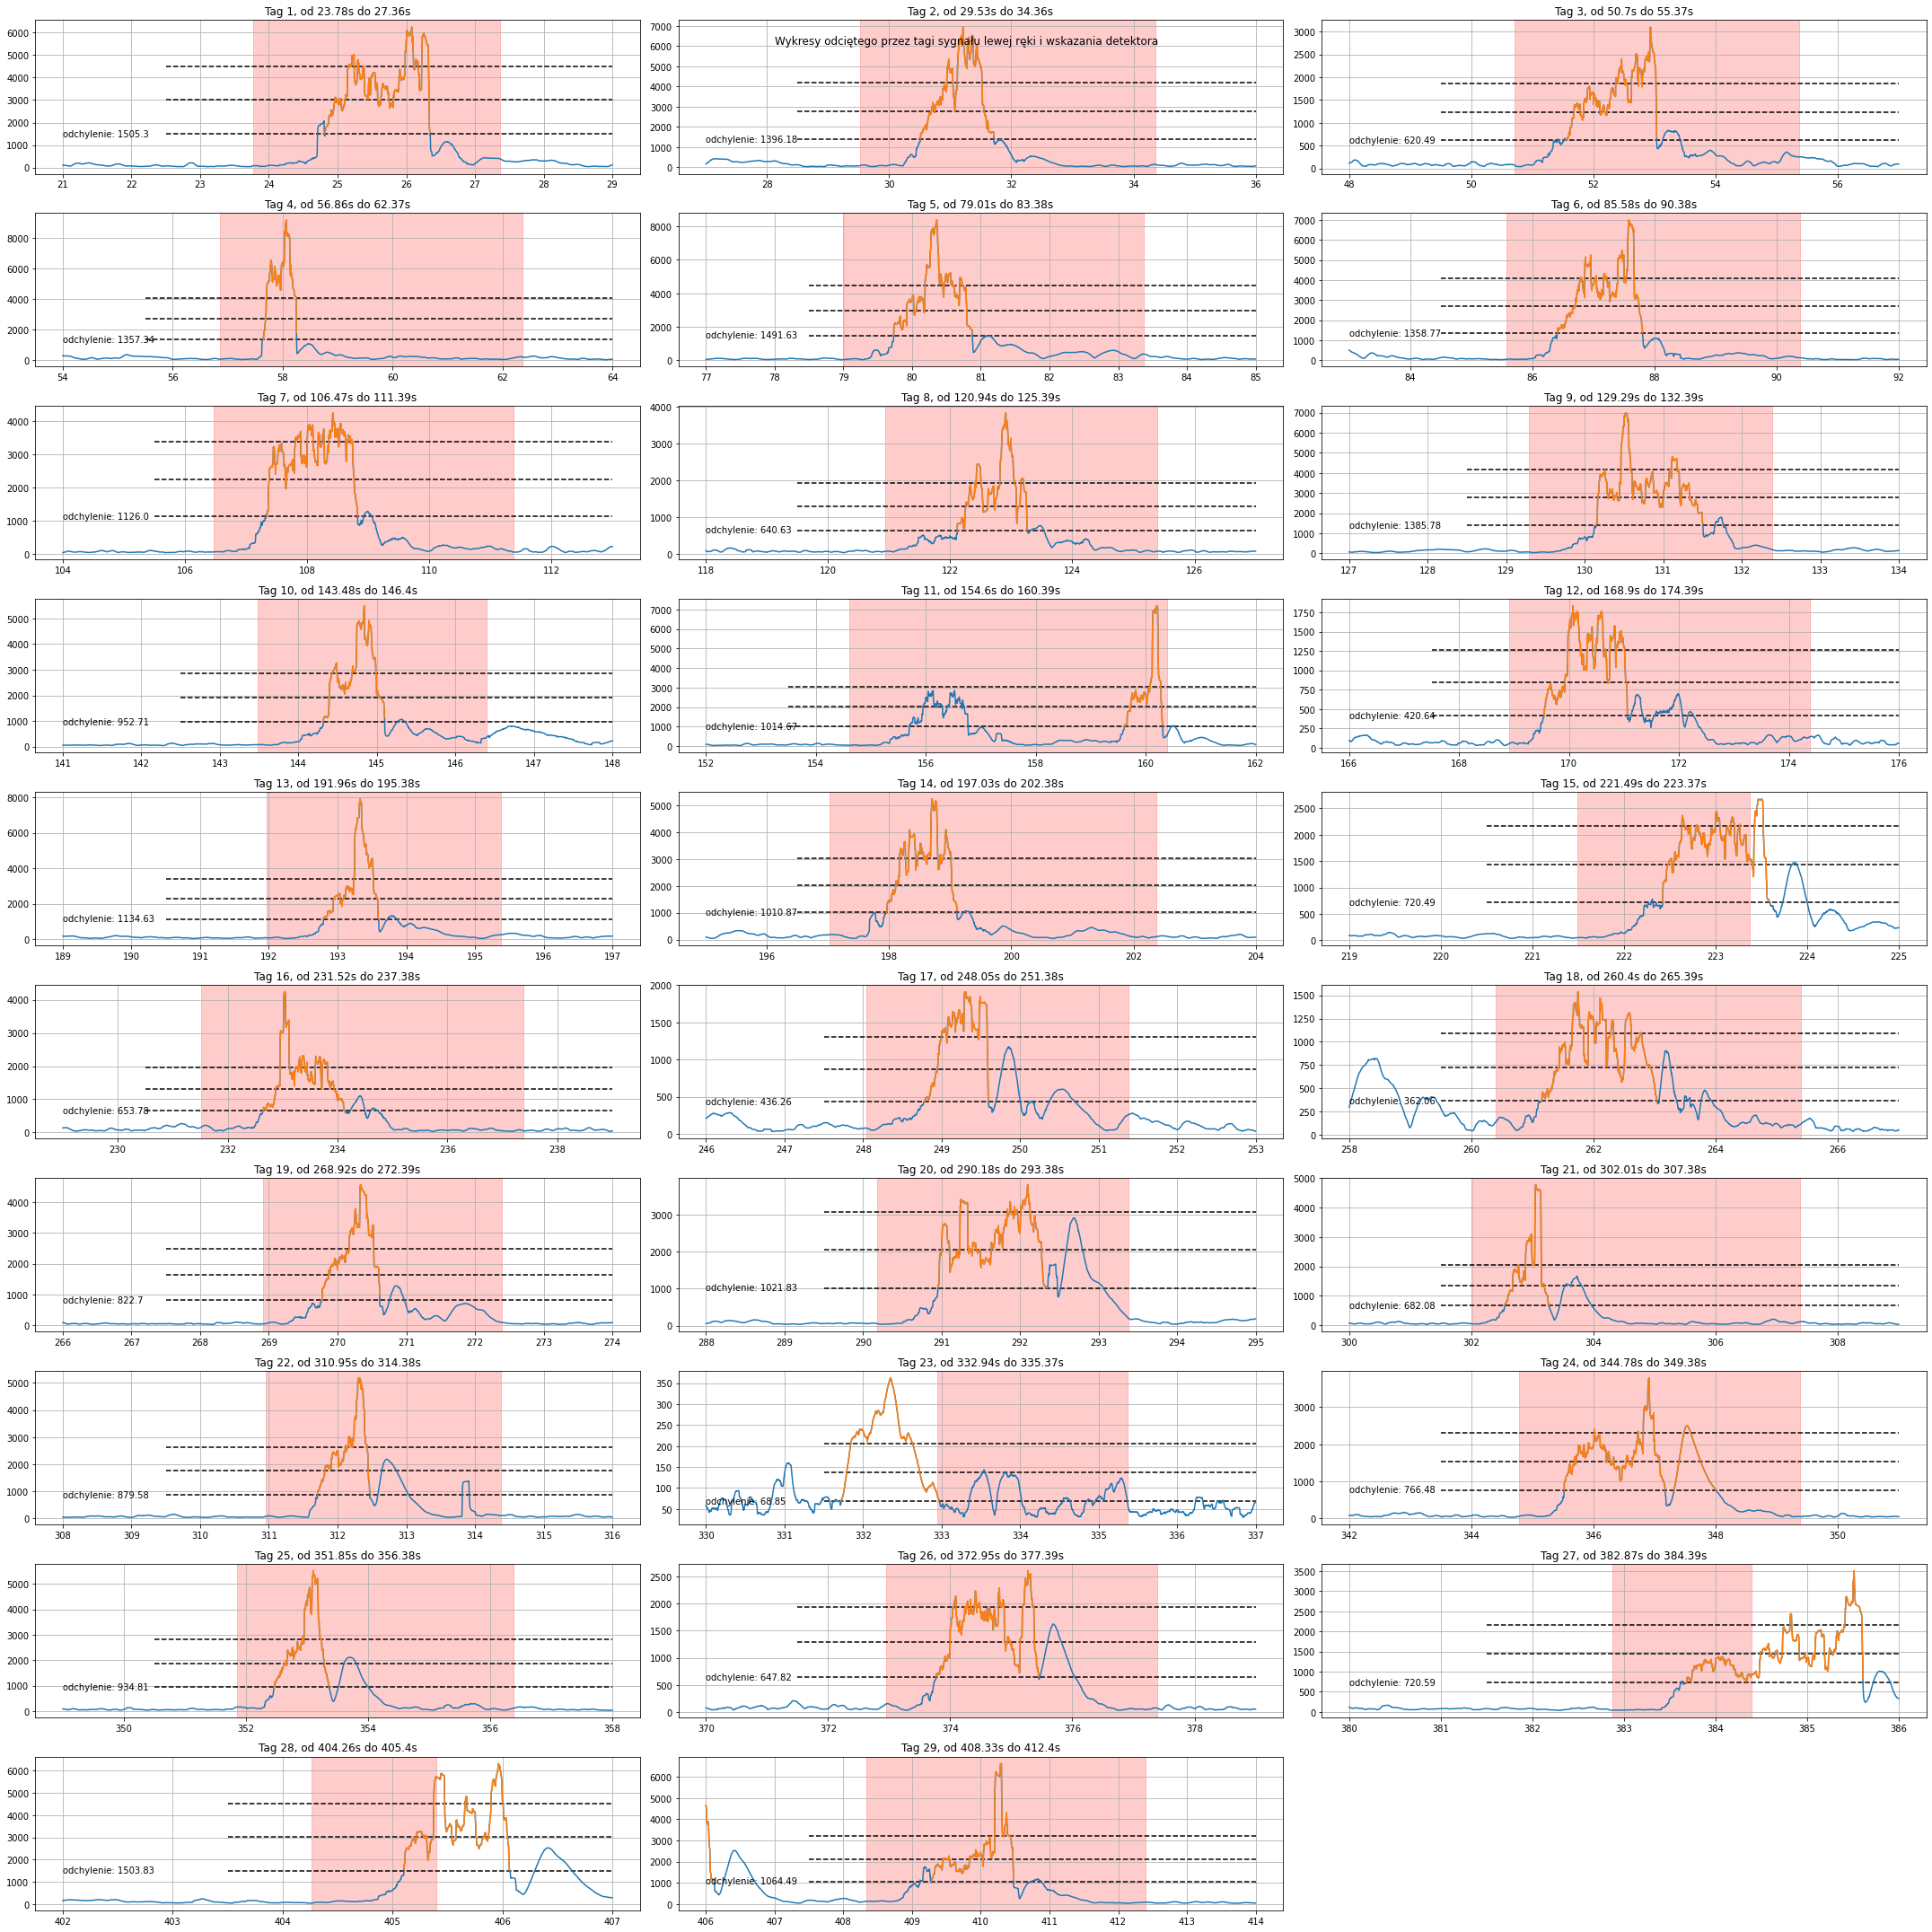

In [19]:
fig = plt.figure(figsize=(30,30))
fig.suptitle('Wykresy odciętego przez tagi sygnału lewej ręki i wskazania detektora')
for zakres, numer in zip(tagi_sygnal_lewa_timestamp, range(len(tagi_sygnal_lewa_timestamp))):
  ax = fig.add_subplot(10, 3, numer+1)
  zakres_dolny = math.floor(zakres[0])-2
  zakres_gorny = math.floor(zakres[1])+2
  ax.axvspan(zakres[0], zakres[1], color='r', alpha=0.2)
  ax.grid()
  
  odchylenie = np.std(syg_lewa_windowed[zakres_dolny*2048:zakres_gorny*2048])
  detektor2 = np.copy(syg_lewa_windowed[zakres_dolny*2048:zakres_gorny*2048])
  wieksze = False
  std3 = False
  start = 0
  tablica_wykryc = []
  for i in range(len(detektor2)):
    if detektor2[i]>odchylenie:
      if wieksze is False:
        start = i
        wieksze = True
      if detektor2[i]>=odchylenie*3 and std3 is False:
        std3 = True
    else:
      if wieksze:
        koniec = i-1
        tablica_wykryc.append((start, i-1, std3))
        std3 = False
        wieksze = False

  plt.hlines(odchylenie, zakres_dolny+1.5, zakres_gorny, linestyles='dashed')
  plt.hlines(odchylenie*2, zakres_dolny+1.5, zakres_gorny, linestyles='dashed')
  plt.hlines(odchylenie*3, zakres_dolny+1.5, zakres_gorny, linestyles='dashed')
  plt.text(zakres_dolny, odchylenie, 'odchylenie: '+str(round(odchylenie,2)), ha='left', va='center')


  kopia_detektor2 = np.empty(np.shape(detektor2))
  kopia_detektor2[:] = np.nan
  for i in tablica_wykryc:
    if i[2] is True:
      kopia_detektor2[i[0]:i[1]] = detektor2[i[0]:i[1]]
  

  ax.plot(np.arange(zakres_dolny, zakres_gorny, 1/2048), syg_lewa_windowed[zakres_dolny*2048:zakres_gorny*2048])
  ax.plot(np.arange(zakres_dolny, zakres_gorny, 1/2048), kopia_detektor2)

  ax.set_title('Tag '+str(numer+1)+', od '+str(round(zakres[0],2))+'s do '+str(round(zakres[1],2))+'s')

fig.tight_layout()
fig.show()

# Porównanie wykryć detektora i tagów dla prawej ręki

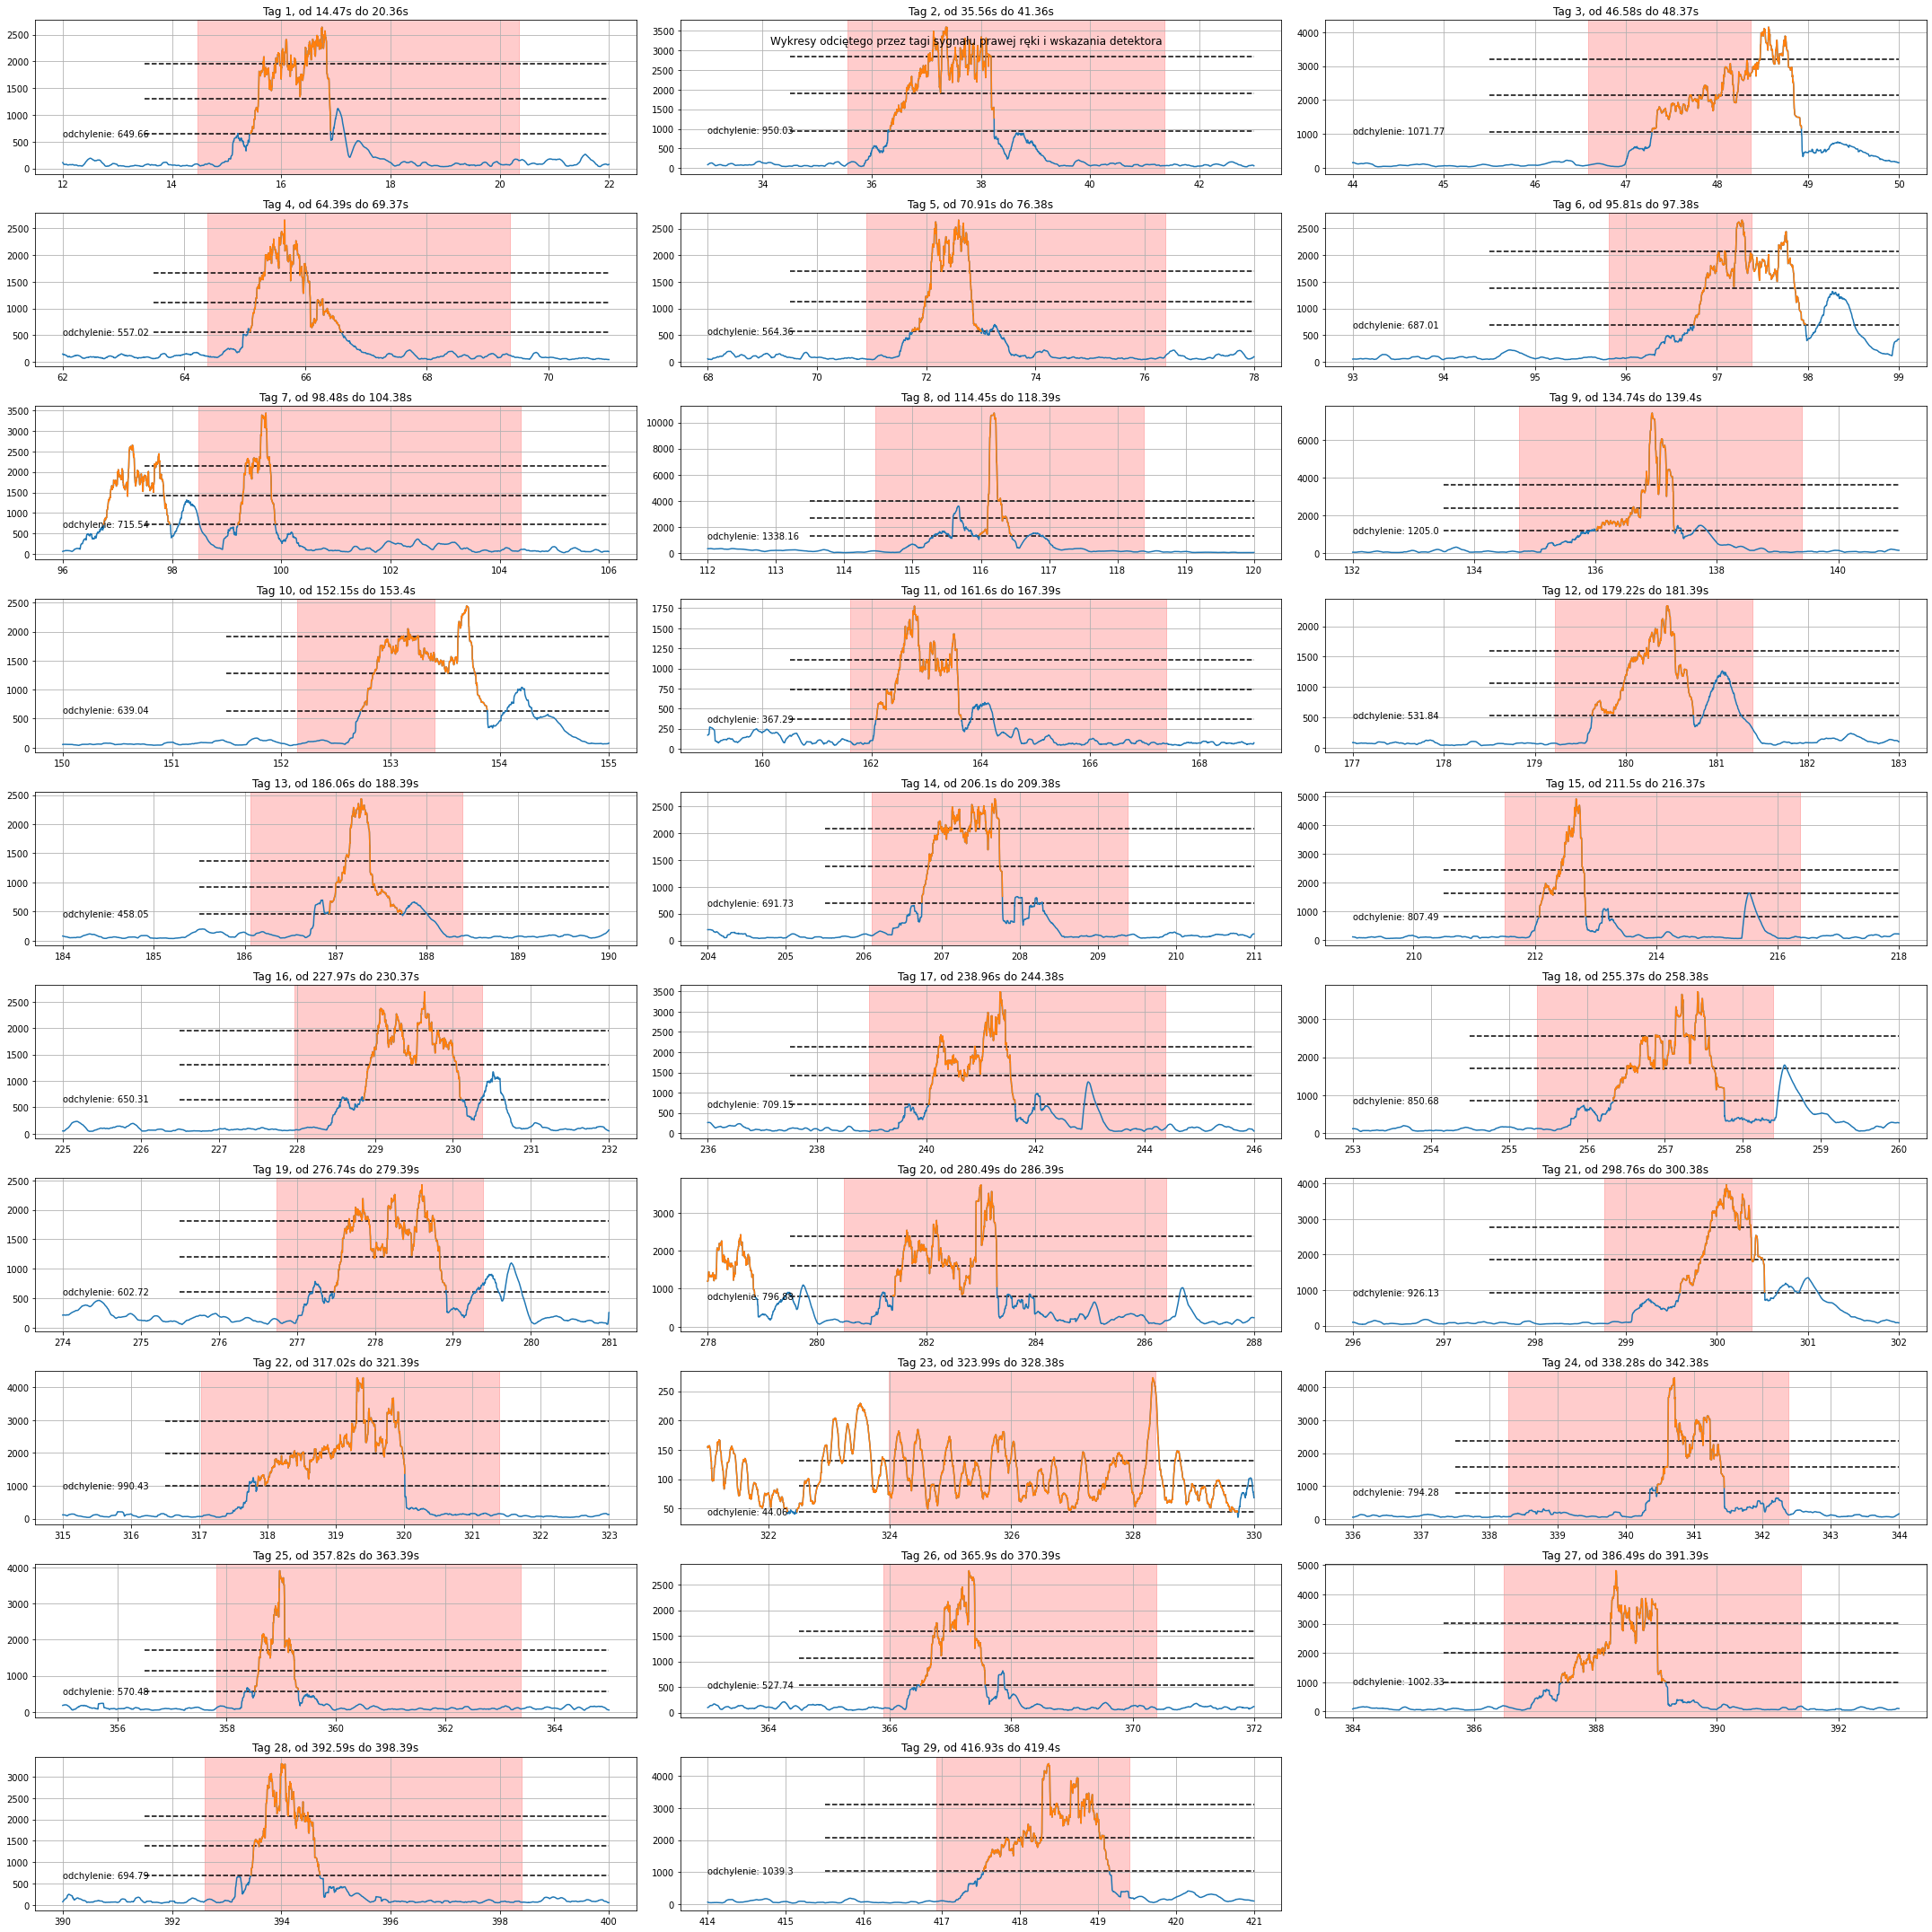

In [ ]:
fig = plt.figure(figsize=(30,30))
fig.suptitle('Wykresy odciętego przez tagi sygnału prawej ręki i wskazania detektora')
for zakres, numer in zip(tagi_sygnal_prawa_timestamp, range(len(tagi_sygnal_prawa_timestamp))):
  ax = fig.add_subplot(10, 3, numer+1)
  zakres_dolny = math.floor(zakres[0])-2
  zakres_gorny = math.floor(zakres[1])+2
  ax.axvspan(zakres[0], zakres[1], color='r', alpha=0.2)
  ax.grid()
  odchylenie = np.std(syg_prawa_windowed[zakres_dolny*2048:zakres_gorny*2048])
  detektor2 = np.copy(syg_prawa_windowed[zakres_dolny*2048:zakres_gorny*2048])
  wieksze = False
  std3 = False
  start = 0
  tablica_wykryc = []
  for i in range(len(detektor2)):
    if detektor2[i]>=odchylenie:
      if wieksze is False:
        start = i
        wieksze = True
      if detektor2[i]>=odchylenie*3 and std3 is False:
        std3 = True
    else:
      if wieksze:
        koniec = i-1
        tablica_wykryc.append((start, i-1, std3))
        std3 = False
        wieksze = False

  plt.hlines(odchylenie, zakres_dolny+1.5, zakres_gorny, linestyles='dashed')
  plt.hlines(odchylenie*2, zakres_dolny+1.5, zakres_gorny, linestyles='dashed')
  plt.hlines(odchylenie*3, zakres_dolny+1.5, zakres_gorny, linestyles='dashed')
  plt.text(zakres_dolny, odchylenie, 'odchylenie: '+str(round(odchylenie,2)), ha='left', va='center')


  kopia_detektor2 = np.empty(np.shape(detektor2))
  kopia_detektor2[:] = np.nan
  for i in tablica_wykryc:
    if i[2] is True:
      kopia_detektor2[i[0]:i[1]] = detektor2[i[0]:i[1]]
  

  ax.plot(np.arange(zakres_dolny, zakres_gorny, 1/2048), syg_prawa_windowed[zakres_dolny*2048:zakres_gorny*2048])
  ax.plot(np.arange(zakres_dolny, zakres_gorny, 1/2048), kopia_detektor2)
  ax.set_title('Tag '+str(numer+1)+', od '+str(round(zakres[0],2))+'s do '+str(round(zakres[1],2))+'s')


fig.tight_layout()
fig.show()